In [1]:
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Price Estimation and Summary Statistics


This notebook demonstrates the price estimation. The data set is then prepared for survival analysis by keeping DOP level between 0.8 and 1.2.

The steps are as follows:

+ OLS regression is applied on data set splits (train - test):
    + Performance measure on the test set is calculated
    + Normality of residuals is tested visually by the Q-Q plot
+ Random Forest is applied on data set splits (train - test):
    + Hyper-parameters are tuned with a further validation split
    + Performance measure on the test set is calculated
    + SHAP values are calculated by using the fitted model, the test set, and 30 K-means of the training data set as default values
    
+ The data set is filtered to keep DOP levels between 0.8 and 1.2

+ Summary statistics for all variables are computed.

+ The counts of censored and noncensored observations by months are visualized

+ The counts of data in 
    







In [23]:
df=pd.read_pickle("ultimate_data/df_price_1901.pkl")
df_info=pd.read_pickle("ultimate_data/df_info_price_1901.pkl")



In [24]:
df.shape, df_info.shape

((915342, 31), (915342, 7))

In [25]:
df

,balcony_available_True,investment_rent_active_True,parking_available_True,object_type_FARMHOUSE,object_type_HOUSE_UNKNOWN,object_type_LOFT,object_type_MAISONETTE,object_type_MANSION,object_type_MULTI_FAMILY_HOUSE,object_type_ONE_TWO_FAMILY_HOUSE,object_type_PENTHOUSE,object_type_REGULAR_APARTMENT,object_type_SEMI_DETACHED_HOUSE,object_type_SPECIAL_BUILDING,object_type_TERRACED_HOUSE,season_Spring,season_Summer,season_Winter,address_lat,address_lng,construction_yearfinished,structure_area_living,structure_rooms_living,zip_population_density,object_type_ordinal,zip_market_size,city_distance,time_online,expose_price_sqm,weeks_on_market,status
0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,48.133854,11.688066,2018.000000,127.000000,6.0,2014.288696,1.0,346.0,0.129487,0.024390,6275.590332,17.0,0.0
1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,48.133854,11.688066,2018.000000,140.000000,6.0,2014.288696,1.0,346.0,0.129487,0.024390,6900.000000,17.0,0.0
2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,51.385792,7.085973,1982.000000,120.000000,4.5,906.219055,7.0,216.0,0.091109,0.231707,1791.666626,1.0,0.0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,52.937435,9.236212,1954.000000,110.000000,5.0,370.996307,1.0,272.0,0.000116,0.024390,2036.363647,13.0,0.0
4,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,52.333286,13.414221,2015.000000,179.000000,5.0,393.366364,3.0,637.0,0.009717,0.219512,6983.240234,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915342,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,52.605518,13.416220,2003.081543,107.000000,4.0,1282.900024,1.0,678.0,0.104998,0.609756,4130.839844,11.0,0.0
915343,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,50.957630,13.920460,2019.000000,144.339996,4.0,449.439209,1.0,1022.0,0.041358,0.756098,1124.005859,1.0,1.0
915344,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,50.868603,6.175504,2018.000000,163.880005,6.0,1470.864746,3.0,752.0,0.000015,0.134146,1617.634888,5.0,0.0
915345,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,50.854256,7.331022,2018.000000,134.000000,4.0,390.568085,3.0,404.0,0.000209,0.024390,1765.052246,14.0,0.0


In [26]:
df.columns

Index(['balcony_available_True', 'investment_rent_active_True', 'parking_available_True', 'object_type_FARMHOUSE', 'object_type_HOUSE_UNKNOWN', 'object_type_LOFT', 'object_type_MAISONETTE', 'object_type_MANSION', 'object_type_MULTI_FAMILY_HOUSE', 'object_type_ONE_TWO_FAMILY_HOUSE', 'object_type_PENTHOUSE', 'object_type_REGULAR_APARTMENT', 'object_type_SEMI_DETACHED_HOUSE', 'object_type_SPECIAL_BUILDING', 'object_type_TERRACED_HOUSE', 'season_Spring', 'season_Summer', 'season_Winter', 'address_lat', 'address_lng', 'construction_yearfinished', 'structure_area_living', 'structure_rooms_living', 'zip_population_density', 'object_type_ordinal', 'zip_market_size', 'city_distance', 'time_online', 'expose_price_sqm', 'weeks_on_market', 'status'], dtype='object')

In [27]:
df.drop(["expose_price_sqm","weeks_on_market","status","object_type_ordinal"], axis = 1).columns

Index(['balcony_available_True', 'investment_rent_active_True', 'parking_available_True', 'object_type_FARMHOUSE', 'object_type_HOUSE_UNKNOWN', 'object_type_LOFT', 'object_type_MAISONETTE', 'object_type_MANSION', 'object_type_MULTI_FAMILY_HOUSE', 'object_type_ONE_TWO_FAMILY_HOUSE', 'object_type_PENTHOUSE', 'object_type_REGULAR_APARTMENT', 'object_type_SEMI_DETACHED_HOUSE', 'object_type_SPECIAL_BUILDING', 'object_type_TERRACED_HOUSE', 'season_Spring', 'season_Summer', 'season_Winter', 'address_lat', 'address_lng', 'construction_yearfinished', 'structure_area_living', 'structure_rooms_living', 'zip_population_density', 'zip_market_size', 'city_distance', 'time_online'], dtype='object')

# OLS Regression

Use 75 percent of the cleaned data set to estimate OLS regression. Then test on the remaining 25 percent.





In [28]:
X = df.drop(["expose_price_sqm","weeks_on_market","status","object_type_ordinal"], axis = 1)
y = np.log(df["expose_price_sqm"])



In [23]:
from sklearn.model_selection import train_test_split
(X_trainval, X_test,
y_trainval, y_test,
idx_trainval, idx_test)= train_test_split(X,y,np.arange(X.shape[0]),test_size = 0.75,random_state= 42)


In [24]:
import statsmodels.api as sm
X_trainval_cons = sm.add_constant(X_trainval)
X_test_cons = sm.add_constant(X_test)

C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [25]:
lr = sm.OLS(y_trainval,X_trainval_cons).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       expose_price_sqm   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     3848.
Date:                Sun, 19 Jan 2020   Prob (F-statistic):               0.00
Time:                        22:03:35   Log-Likelihood:            -1.5056e+05
No. Observations:              228835   AIC:                         3.012e+05
Df Residuals:                  228807   BIC:                         3.015e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                6.8006      0.054    125.468      0.000       6.694       6.907
balcony_available_True               0.1078      0.002     49.198      0.000       0.104       0.112
investment_rent_active_True         -0.0989      0.003    -37.252      0.000      -0.104      -0.094
parking_available_True               0.1286      0.002     61.192      0.000       0.124       0.133
object_type_FARMHOUSE               -0.1758      0.014    -12.241      0.000      -0.204      -0.148
object_type_HOUSE_UNKNOWN           -0.0262      0.007     -3.562      0.000      -0.041      -0.012
object_type_LOFT                     0.0466      0.030      1.537      0.124      -0.013       0.106
object_type_MAISONETTE               0.0429      0.010      4.364      0.000       0.024       0.062
object_type_MANSION                  0.1652      0.012     13.931      0.000       0.142       0.188
object_type_MULTI_FAMILY_HOUSE      -0.1993      0.008    -24.330      0.000      -0.215      -0.183
object_type_ONE_TWO_FAMILY_HOUSE    -0.0803      0.007    -11.869      0.000      -0.094      -0.067
object_type_PENTHOUSE                0.2622      0.013     20.584      0.000       0.237       0.287
object_type_REGULAR_APARTMENT       -0.0488      0.007     -7.058      0.000      -0.062      -0.035
object_type_SEMI_DETACHED_HOUSE      0.0791      0.008     10.079      0.000       0.064       0.094
object_type_SPECIAL_BUILDING        -0.1612      0.008    -19.065      0.000      -0.178      -0.145
object_type_TERRACED_HOUSE           0.0369      0.008      4.439      0.000       0.021       0.053
season_Spring                        0.0102      0.003      3.227      0.001       0.004       0.016
season_Summer                        0.0098      0.003      2.840      0.005       0.003       0.017
season_Winter                       -0.0016      0.003     -0.481      0.631      -0.008       0.005
address_lat                         -0.0758      0.001   -131.172      0.000      -0.077      -0.075
address_lng                          0.0199      0.000     43.059      0.000       0.019       0.021
construction_yearfinished            0.0022   2.14e-05    102.561      0.000       0.002       0.002
structure_area_living                0.0002   2.37e-05      8.948      0.000       0.000       0.000
structure_rooms_living              -0.0237      0.001    -30.418      0.000      -0.025      -0.022
zip_population_density            7.937e-05    4.3e-07    184.405      0.000    7.85e-05    8.02e-05
zip_market_size                      0.0003   3.85e-06     68.060      0.000       0.000       0.000
city_distance                        0.0077      0.004      2.079      0.038       0.000       0.015
time_online                          0.0909      0.00

In [100]:
from sklearn.metrics import mean_squared_error
print("train error: ",mean_squared_error(y_trainval,lr.predict(X_trainval_cons)))
print("test error: ",mean_squared_error(y_test,lr.predict(X_test_cons)))

train error:  0.21828477107086977
test error:  0.21796364063258458


In [29]:
mlr_pred_train = lr.predict(X_trainval_cons)
residuals = y_trainval - mlr_pred_train




# OLS, Normality of Residuals

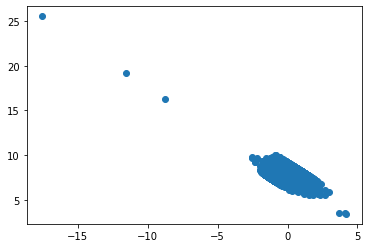

In [31]:
fig, ax = plt.subplots()
ax.scatter(residuals, mlr_pred_train)

In [51]:
residuals.max()

4.211713979572713

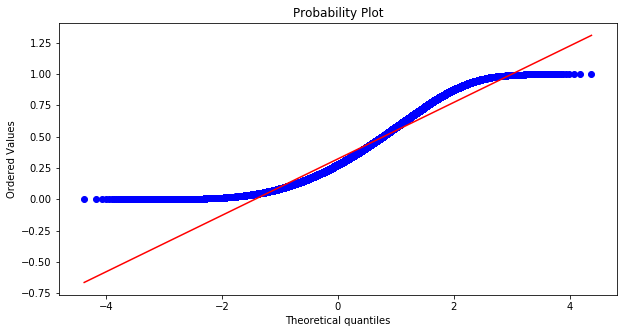

In [58]:
import scipy as sp
fig, ax = plt.subplots(figsize=(10,5))
_, (__, ___, r) = sp.stats.probplot(residuals[(residuals>0)&(residuals < 1)], plot=ax, fit=True)

plt.savefig("qqplot_mlr.pdf")

In [37]:
X_trainval_cons.columns

Index(['const', 'balcony_available_True', 'investment_rent_active_True', 'parking_available_True', 'object_type_FARMHOUSE', 'object_type_HOUSE_UNKNOWN', 'object_type_LOFT', 'object_type_MAISONETTE', 'object_type_MANSION', 'object_type_MULTI_FAMILY_HOUSE', 'object_type_ONE_TWO_FAMILY_HOUSE', 'object_type_PENTHOUSE', 'object_type_REGULAR_APARTMENT', 'object_type_SEMI_DETACHED_HOUSE', 'object_type_SPECIAL_BUILDING', 'object_type_TERRACED_HOUSE', 'season_Spring', 'season_Summer', 'season_Winter', 'address_lat', 'address_lng', 'construction_yearfinished', 'structure_area_living', 'structure_rooms_living', 'zip_population_density', 'zip_market_size', 'city_distance', 'time_online'], dtype='object')

# Random Forest

In [68]:
df.columns

Index(['balcony_available_True', 'investment_rent_active_True', 'parking_available_True', 'object_type_FARMHOUSE', 'object_type_HOUSE_UNKNOWN', 'object_type_LOFT', 'object_type_MAISONETTE', 'object_type_MANSION', 'object_type_MULTI_FAMILY_HOUSE', 'object_type_ONE_TWO_FAMILY_HOUSE', 'object_type_PENTHOUSE', 'object_type_REGULAR_APARTMENT', 'object_type_SEMI_DETACHED_HOUSE', 'object_type_SPECIAL_BUILDING', 'object_type_TERRACED_HOUSE', 'season_Spring', 'season_Summer', 'season_Winter', 'address_lat', 'address_lng', 'construction_yearfinished', 'structure_area_living', 'structure_rooms_living', 'zip_population_density', 'object_type_ordinal', 'zip_market_size', 'city_distance', 'time_online', 'expose_price_sqm', 'weeks_on_market', 'status'], dtype='object')

In [29]:
selected_cols=[col for col in df.columns if (col[:11] != "object_type" or col == "object_type_ordinal") 
 and col not in ["expose_price_sqm","weeks_on_market","status"] ]



In [30]:
selected_cols

['balcony_available_True',
 'investment_rent_active_True',
 'parking_available_True',
 'season_Spring',
 'season_Summer',
 'season_Winter',
 'address_lat',
 'address_lng',
 'construction_yearfinished',
 'structure_area_living',
 'structure_rooms_living',
 'zip_population_density',
 'object_type_ordinal',
 'zip_market_size',
 'city_distance',
 'time_online']

In [31]:
X = df[selected_cols]
y = np.log(df["expose_price_sqm"])


In [32]:
from sklearn.model_selection import train_test_split
(X_trainval, X_test,
y_trainval, y_test,
idx_trainval, idx_test)= train_test_split(X,y,np.arange(X.shape[0]),test_size = 0.75,random_state= 42)


In [33]:
from sklearn.model_selection import train_test_split

(X_train, X_val,
y_train, y_val )= train_test_split(X_trainval,y_trainval,test_size = 0.3,random_state= 42)


In [83]:
X_train.shape,X_val.shape,X_test.shape

((160184, 16), (68651, 16), (686507, 16))

# Hyperparameter Tuning for Random Forest

In [122]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle
import time

RANDOM_STATE = 42

ensemble_clfs = [
      ("max_features=3",
        RandomForestRegressor(warm_start=True, max_features=3,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("max_features=5",
        RandomForestRegressor(warm_start=True, max_features=5,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("max_features=7",
        RandomForestRegressor(warm_start=True, max_features=7,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("max_features=9",
        RandomForestRegressor(warm_start=True, max_features=9,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("max_features=11",
        RandomForestRegressor(warm_start=True, max_features=11,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("max_features=13",
        RandomForestRegressor(warm_start=True, max_features=13,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
min_estimators = 1
max_estimators = 200


for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators):
        print(label," ",i," trees\n")
        start = time.time()
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)
        
        oob_error = mean_squared_error(y_val, clf.predict(X_val))
        # Record the OOB error for each `n_estimators=i` setting.
        #oob_error = clf.oob_score_
        print("    OOB MSE: ",oob_error )
        error_rate[label].append((i, oob_error))
        
        with open('ultimate_data/rf_grid_error_final.pkl', 'wb') as handle:
            pickle.dump(error_rate, handle)
        
        print("     Time: ", time.time() - start,"\n")

max_features=3   1  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.23497513999853728
     Time:  0.7636282444000244 

max_features=3   2  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.1605246318648076
     Time:  0.972463846206665 

max_features=3   3  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.13864209131776772
     Time:  1.0097756385803223 

max_features=3   4  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.12517886928234073
     Time:  1.0897250175476074 

max_features=3   5  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.11680998048753721
     Time:  1.2709038257598877 

max_features=3   6  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.11117925567146651
     Time:  1.2708423137664795 

max_features=3   7  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.10836058686297456
     Time:  1.387007236480713 

max_features=3   8  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.10642164577961333
     Time:  1.4457480907440186 

max_features=3   9  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.10415748377868796
     Time:  1.7803623676300049 

max_features=3   10  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.10139122687633825
     Time:  1.8562068939208984 

max_features=3   11  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09943098459118144
     Time:  1.7351353168487549 

max_features=3   12  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09898856938156927
     Time:  1.8911678791046143 

max_features=3   13  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09777008930787955
     Time:  1.9478123188018799 

max_features=3   14  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09677361200727909
     Time:  2.0447750091552734 

max_features=3   15  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09601567196493592
     Time:  2.1972243785858154 

max_features=3   16  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09517061362210665
     Time:  2.2456066608428955 

max_features=3   17  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.094805393402284
     Time:  2.23271107673645 

max_features=3   18  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09405431215227082
     Time:  2.543044328689575 

max_features=3   19  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09394624296912749
     Time:  2.8194613456726074 

max_features=3   20  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09382197453825646
     Time:  2.5292937755584717 

max_features=3   21  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09361069117210924
     Time:  2.7023704051971436 

max_features=3   22  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0930799605412933
     Time:  2.9654922485351562 

max_features=3   23  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09248588472803469
     Time:  3.41504168510437 

max_features=3   24  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09239893677366637
     Time:  3.5739617347717285 

max_features=3   25  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09200611566628884
     Time:  3.2306699752807617 

max_features=3   26  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.091557290050591
     Time:  3.16049861907959 

max_features=3   27  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09113143806544088
     Time:  3.376797914505005 

max_features=3   28  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09093608010382734
     Time:  3.284667491912842 

max_features=3   29  trees

    OOB MSE:  0.09082850679663608
     Time:  3.8720829486846924 

max_features=3   30  trees

    OOB MSE:  0.090805231419268
     Time:  4.085181713104248 

max_features=3   31  trees

    OOB MSE:  0.09058537084001499
     Time:  4.009710073471069 

max_features=3   32  trees

    OOB MSE:  0.0905684586009196
     Time:  3.8483548164367676 

max_features=3   33  trees

    OOB MSE:  0.09026996336573757
     Time:  3.684899091720581 

max_features=3   34  trees

    OOB MSE:  0.09000042571050147
     Time:  4.42067813873291 

max_features=3   35  trees

    OOB MSE:  0.0898141739550164
     Time:  4.718229055404663 

max_features=3   36  trees

    OOB MSE:  0.089658193381871
     Time:  5.59969687461853 

max_features=3   37  trees

    OOB MSE:  0.08957123731826484
     Time:  4.447116136550903 

max_features=3   38  trees

    OOB MSE:  0.08933857012544764
     Time:  4.731531620025635 



    OOB MSE:  0.08659259647674011
     Time:  14.230907201766968 

max_features=3   116  trees

    OOB MSE:  0.0866258117553845
     Time:  14.416494607925415 

max_features=3   117  trees

    OOB MSE:  0.08656804306876005
     Time:  14.358547687530518 

max_features=3   118  trees

    OOB MSE:  0.08656549220161155
     Time:  14.756415128707886 

max_features=3   119  trees

    OOB MSE:  0.08647063477569243
     Time:  14.826791763305664 

max_features=3   120  trees

    OOB MSE:  0.08640214794646965
     Time:  15.34558391571045 

max_features=3   121  trees

    OOB MSE:  0.08637723045385157
     Time:  15.290352582931519 

max_features=3   122  trees

    OOB MSE:  0.08641731499606561
     Time:  15.020293712615967 

max_features=3   123  trees

    OOB MSE:  0.08636263158718159
     Time:  15.038729667663574 

max_features=3   124  trees

    OOB MSE:  0.08636422440052721
     Time:  15.113443851470947 

max_features=3   125  trees

    OOB MSE:  0.08634858485005344
     Tim

C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.18740851472539852
     Time:  1.041487216949463 

max_features=5   2  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.1350741436764351
     Time:  1.1278979778289795 

max_features=5   3  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.11526857933313338
     Time:  1.275650978088379 

max_features=5   4  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.10437895562030004
     Time:  1.492187738418579 

max_features=5   5  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09849351224944343
     Time:  1.5849215984344482 

max_features=5   6  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09437079736307517
     Time:  1.6784155368804932 

max_features=5   7  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09226311719284361
     Time:  1.7810468673706055 

max_features=5   8  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0902903516571507
     Time:  2.059253692626953 

max_features=5   9  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08891747778956378
     Time:  2.0550999641418457 

max_features=5   10  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08724562021421367
     Time:  2.1447157859802246 

max_features=5   11  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08623515163723372
     Time:  2.2979609966278076 

max_features=5   12  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08562244812556827
     Time:  2.3110880851745605 

max_features=5   13  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08526931838721288
     Time:  2.546299457550049 

max_features=5   14  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08481449438942673
     Time:  2.5498197078704834 

max_features=5   15  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0844588286901941
     Time:  2.726699113845825 

max_features=5   16  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08400918994632162
     Time:  2.861839771270752 

max_features=5   17  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0837496058663475
     Time:  2.884850263595581 

max_features=5   18  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08327031411445897
     Time:  3.121525526046753 

max_features=5   19  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08314065187319325
     Time:  3.1338436603546143 

max_features=5   20  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0828789528699189
     Time:  3.269806146621704 

max_features=5   21  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08257255573464234
     Time:  3.3145101070404053 

max_features=5   22  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08232533407926747
     Time:  3.504310369491577 

max_features=5   23  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08202879466209281
     Time:  3.6450860500335693 

max_features=5   24  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0818971524666487
     Time:  3.734090566635132 

max_features=5   25  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08173637463857705
     Time:  3.8618834018707275 

max_features=5   26  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08161723957628529
     Time:  3.874549627304077 

max_features=5   27  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08157325095716386
     Time:  4.025322914123535 

max_features=5   28  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08147614374050216
     Time:  4.121180295944214 

max_features=5   29  trees

    OOB MSE:  0.08140071868838937
     Time:  4.328222274780273 

max_features=5   30  trees

    OOB MSE:  0.0812027892341027
     Time:  4.41825270652771 

max_features=5   31  trees

    OOB MSE:  0.0810588517642767
     Time:  4.542293071746826 

max_features=5   32  trees

    OOB MSE:  0.08089308152518203
     Time:  4.784425735473633 

max_features=5   33  trees

    OOB MSE:  0.08072218664852854
     Time:  4.760834217071533 

max_features=5   34  trees

    OOB MSE:  0.08067779834254578
     Time:  4.864248991012573 

max_features=5   35  trees

    OOB MSE:  0.08053157647117812
     Time:  4.886298894882202 

max_features=5   36  trees

    OOB MSE:  0.08040025143220285
     Time:  5.062493085861206 

max_features=5   37  trees

    OOB MSE:  0.08037307666570437
     Time:  5.151818513870239 

max_features=5   38  trees

    OOB MSE:  0.08024443661060258
     Time:  5.679627418518066

    OOB MSE:  0.0779248486489516
     Time:  13.986793279647827 

max_features=5   116  trees

    OOB MSE:  0.07791739988699573
     Time:  14.967926263809204 

max_features=5   117  trees

    OOB MSE:  0.07791509077301026
     Time:  14.091023206710815 

max_features=5   118  trees

    OOB MSE:  0.07791224363016559
     Time:  15.398635149002075 

max_features=5   119  trees

    OOB MSE:  0.07788550255949404
     Time:  14.883845806121826 

max_features=5   120  trees

    OOB MSE:  0.07785755936434086
     Time:  14.614672899246216 

max_features=5   121  trees

    OOB MSE:  0.07780543976518683
     Time:  14.514142513275146 

max_features=5   122  trees

    OOB MSE:  0.07781249997846129
     Time:  16.464329957962036 

max_features=5   123  trees

    OOB MSE:  0.07782747557854684
     Time:  15.995962858200073 

max_features=5   124  trees

    OOB MSE:  0.07783689188209154
     Time:  16.856680393218994 

max_features=5   125  trees

    OOB MSE:  0.07784955446273278
     Ti

C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.17722432182837192
     Time:  1.8095500469207764 

max_features=7   2  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.12586208856764278
     Time:  1.598771572113037 

max_features=7   3  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.11034102225257865
     Time:  1.9086387157440186 

max_features=7   4  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.10068880366521805
     Time:  1.9247767925262451 

max_features=7   5  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09563436888933027
     Time:  1.9922165870666504 

max_features=7   6  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09238972168619063
     Time:  2.487529754638672 

max_features=7   7  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09013284805525011
     Time:  2.48346209526062 

max_features=7   8  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08787720436386122
     Time:  2.59097957611084 

max_features=7   9  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08650958409407776
     Time:  2.5097544193267822 

max_features=7   10  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08532154007294417
     Time:  2.725931167602539 

max_features=7   11  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08429654613557493
     Time:  2.9307548999786377 

max_features=7   12  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08359973898593723
     Time:  2.894925117492676 

max_features=7   13  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08286401152566716
     Time:  2.985370397567749 

max_features=7   14  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08232200982513498
     Time:  3.062755823135376 

max_features=7   15  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08193449333947173
     Time:  3.5002572536468506 

max_features=7   16  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08147506432028488
     Time:  3.337843894958496 

max_features=7   17  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08102271972987232
     Time:  3.2530629634857178 

max_features=7   18  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08064748518230115
     Time:  3.8210926055908203 

max_features=7   19  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0803565430292111
     Time:  3.8642570972442627 

max_features=7   20  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08002956284568322
     Time:  3.6351535320281982 

max_features=7   21  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07967224196323346
     Time:  4.357138156890869 

max_features=7   22  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07945055184626577
     Time:  4.2373738288879395 

max_features=7   23  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0791703102490852
     Time:  4.221000671386719 

max_features=7   24  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07896237792580652
     Time:  4.382006645202637 

max_features=7   25  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07884749024794835
     Time:  4.554676055908203 

max_features=7   26  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0787280661119749
     Time:  4.979223251342773 

max_features=7   27  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0786066027117095
     Time:  5.019216775894165 

max_features=7   28  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0784694237954532
     Time:  4.9183313846588135 

max_features=7   29  trees

    OOB MSE:  0.07834330308212116
     Time:  5.356717109680176 

max_features=7   30  trees

    OOB MSE:  0.07822454664879613
     Time:  5.075215101242065 

max_features=7   31  trees

    OOB MSE:  0.07815664897360543
     Time:  5.028770208358765 

max_features=7   32  trees

    OOB MSE:  0.07804429128156241
     Time:  5.287984132766724 

max_features=7   33  trees

    OOB MSE:  0.07797298867383948
     Time:  5.380232572555542 

max_features=7   34  trees

    OOB MSE:  0.07786546023296914
     Time:  5.44521427154541 

max_features=7   35  trees

    OOB MSE:  0.07773281375166617
     Time:  6.307145833969116 

max_features=7   36  trees

    OOB MSE:  0.07762589656666817
     Time:  6.025457382202148 

max_features=7   37  trees

    OOB MSE:  0.07755979038516672
     Time:  5.6839540004730225 

max_features=7   38  trees

    OOB MSE:  0.07746214634729563
     Time:  6.054302930831

    OOB MSE:  0.0756621553638655
     Time:  15.049590349197388 

max_features=7   116  trees

    OOB MSE:  0.0756588723223929
     Time:  15.103093385696411 

max_features=7   117  trees

    OOB MSE:  0.07564115806199316
     Time:  15.306018114089966 

max_features=7   118  trees

    OOB MSE:  0.07563128756011542
     Time:  15.830080509185791 

max_features=7   119  trees

    OOB MSE:  0.07563897362591088
     Time:  17.42908787727356 

max_features=7   120  trees

    OOB MSE:  0.07562756975552394
     Time:  15.790961027145386 

max_features=7   121  trees

    OOB MSE:  0.07562930214805383
     Time:  15.685085535049438 

max_features=7   122  trees

    OOB MSE:  0.07562413346449205
     Time:  16.297003269195557 

max_features=7   123  trees

    OOB MSE:  0.07562177149295457
     Time:  16.19549298286438 

max_features=7   124  trees

    OOB MSE:  0.07561731217956245
     Time:  16.091524600982666 

max_features=7   125  trees

    OOB MSE:  0.0756128475973799
     Time: 

C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.1733096650256806
     Time:  1.9657695293426514 

max_features=9   2  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.12365281261360088
     Time:  2.1182351112365723 

max_features=9   3  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.10742644544160582
     Time:  2.304011821746826 

max_features=9   4  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09884258849738534
     Time:  2.412559986114502 

max_features=9   5  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09432348361702
     Time:  2.4805221557617188 

max_features=9   6  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0910762151022217
     Time:  2.576456308364868 

max_features=9   7  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0890554142213702
     Time:  2.7303688526153564 

max_features=9   8  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08710218826115901
     Time:  2.914126396179199 

max_features=9   9  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08561740307450687
     Time:  2.8794286251068115 

max_features=9   10  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08453980906856526
     Time:  3.06358003616333 

max_features=9   11  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08368876109093654
     Time:  3.184082508087158 

max_features=9   12  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08299210678839473
     Time:  3.456002712249756 

max_features=9   13  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08225147082812469
     Time:  3.5271353721618652 

max_features=9   14  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08170955359457521
     Time:  3.516671657562256 

max_features=9   15  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0812110004485948
     Time:  3.75008487701416 

max_features=9   16  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08080934434042969
     Time:  3.771221399307251 

max_features=9   17  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08043557598145232
     Time:  3.884618043899536 

max_features=9   18  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0800585024500492
     Time:  4.004820346832275 

max_features=9   19  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07964071008085263
     Time:  4.143165111541748 

max_features=9   20  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07936466066387857
     Time:  4.216482639312744 

max_features=9   21  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0791221514654888
     Time:  4.329080581665039 

max_features=9   22  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07896108446885781
     Time:  4.469239950180054 

max_features=9   23  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07883735859702244
     Time:  4.559211492538452 

max_features=9   24  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07865750829910473
     Time:  4.628962278366089 

max_features=9   25  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07847125632293564
     Time:  4.855953931808472 

max_features=9   26  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07831607306283282
     Time:  4.897222518920898 

max_features=9   27  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0782225257619927
     Time:  5.099366664886475 

max_features=9   28  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07806284862564025
     Time:  5.173867464065552 

max_features=9   29  trees

    OOB MSE:  0.07787758555930671
     Time:  5.345334529876709 

max_features=9   30  trees

    OOB MSE:  0.07773631040537929
     Time:  5.497314929962158 

max_features=9   31  trees

    OOB MSE:  0.07769289814360308
     Time:  5.504825592041016 

max_features=9   32  trees

    OOB MSE:  0.07759739054337096
     Time:  5.718421220779419 

max_features=9   33  trees

    OOB MSE:  0.07747165158842755
     Time:  5.7248029708862305 

max_features=9   34  trees

    OOB MSE:  0.0773928259339928
     Time:  5.793500185012817 

max_features=9   35  trees

    OOB MSE:  0.07731667438845306
     Time:  5.958955764770508 

max_features=9   36  trees

    OOB MSE:  0.07724553277112203
     Time:  6.037808895111084 

max_features=9   37  trees

    OOB MSE:  0.07724109218026044
     Time:  6.362025499343872 

max_features=9   38  trees

    OOB MSE:  0.07713720489957826
     Time:  6.329420566558

    OOB MSE:  0.07528507607753498
     Time:  8.377354145050049 

max_features=9   116  trees

    OOB MSE:  0.0752790066155801
     Time:  7.826977491378784 

max_features=9   117  trees

    OOB MSE:  0.07526946706375655
     Time:  8.169111728668213 

max_features=9   118  trees

    OOB MSE:  0.07526910511513989
     Time:  8.522586345672607 

max_features=9   119  trees

    OOB MSE:  0.07525198658685282
     Time:  8.391090154647827 

max_features=9   120  trees

    OOB MSE:  0.07524058056220227
     Time:  10.143234968185425 

max_features=9   121  trees

    OOB MSE:  0.0752329701669831
     Time:  8.739902973175049 

max_features=9   122  trees

    OOB MSE:  0.07522937564906008
     Time:  10.095791339874268 

max_features=9   123  trees

    OOB MSE:  0.07521766989428942
     Time:  8.17338490486145 

max_features=9   124  trees

    OOB MSE:  0.07521640829515386
     Time:  8.003296852111816 

max_features=9   125  trees

    OOB MSE:  0.07521554249435072
     Time:  8.101

C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.16876001838483062
     Time:  1.2296810150146484 

max_features=11   2  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.12219542926915507
     Time:  1.4022939205169678 

max_features=11   3  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.10673909804378028
     Time:  1.2883367538452148 

max_features=11   4  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09883976366221212
     Time:  1.3853282928466797 

max_features=11   5  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0940011634622625
     Time:  1.369372844696045 

max_features=11   6  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09103498992970224
     Time:  1.4839980602264404 

max_features=11   7  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08842321525488467
     Time:  1.7582957744598389 

max_features=11   8  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0870293638389283
     Time:  1.6625559329986572 

max_features=11   9  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08584289851705855
     Time:  1.6226911544799805 

max_features=11   10  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08465100960502495
     Time:  1.7143807411193848 

max_features=11   11  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08366967788872817
     Time:  1.8201322555541992 

max_features=11   12  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0829800203470541
     Time:  1.8710708618164062 

max_features=11   13  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08225934979331878
     Time:  1.9118866920471191 

max_features=11   14  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08164539957257096
     Time:  1.9827444553375244 

max_features=11   15  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08115347514839398
     Time:  2.070502281188965 

max_features=11   16  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08064595124488351
     Time:  2.0774309635162354 

max_features=11   17  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08022378996959899
     Time:  2.141324281692505 

max_features=11   18  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07993788682483687
     Time:  2.215625524520874 

max_features=11   19  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07974745822398402
     Time:  2.2369890213012695 

max_features=11   20  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07947380239187733
     Time:  2.3207926750183105 

max_features=11   21  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07925112001810186
     Time:  2.3593027591705322 

max_features=11   22  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07900577055225617
     Time:  2.61592173576355 

max_features=11   23  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07879431153372929
     Time:  2.7335309982299805 

max_features=11   24  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07862137631141919
     Time:  4.085692405700684 

max_features=11   25  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07847877137822788
     Time:  3.378962278366089 

max_features=11   26  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0783405154674814
     Time:  3.352128028869629 

max_features=11   27  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07816801957729708
     Time:  3.2117278575897217 

max_features=11   28  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07805693530197981
     Time:  3.3670313358306885 

max_features=11   29  trees

    OOB MSE:  0.07791574025297955
     Time:  2.862889528274536 

max_features=11   30  trees

    OOB MSE:  0.07778051436720912
     Time:  2.793297529220581 

max_features=11   31  trees

    OOB MSE:  0.07764601442649777
     Time:  3.153578758239746 

max_features=11   32  trees

    OOB MSE:  0.07759615391844205
     Time:  3.7466342449188232 

max_features=11   33  trees

    OOB MSE:  0.0775654008788241
     Time:  3.614365339279175 

max_features=11   34  trees

    OOB MSE:  0.07750298575356059
     Time:  3.5196313858032227 

max_features=11   35  trees

    OOB MSE:  0.07741575257720895
     Time:  3.0927343368530273 

max_features=11   36  trees

    OOB MSE:  0.0773258012382879
     Time:  3.1231906414031982 

max_features=11   37  trees

    OOB MSE:  0.07725634658246289
     Time:  4.1279661655426025 

max_features=11   38  trees

    OOB MSE:  0.07720317633967584
     Time:  

    OOB MSE:  0.07521841143113972
     Time:  7.733328580856323 

max_features=11   116  trees

    OOB MSE:  0.07521215060348939
     Time:  7.791051149368286 

max_features=11   117  trees

    OOB MSE:  0.07520851710426849
     Time:  7.837415456771851 

max_features=11   118  trees

    OOB MSE:  0.07521183990016425
     Time:  7.887687921524048 

max_features=11   119  trees

    OOB MSE:  0.07520437743722279
     Time:  7.93731164932251 

max_features=11   120  trees

    OOB MSE:  0.07518516296622021
     Time:  8.011675357818604 

max_features=11   121  trees

    OOB MSE:  0.07516588180931885
     Time:  8.970340728759766 

max_features=11   122  trees

    OOB MSE:  0.07516412064212585
     Time:  9.016133785247803 

max_features=11   123  trees

    OOB MSE:  0.0751531973524229
     Time:  8.50252366065979 

max_features=11   124  trees

    OOB MSE:  0.07512562855087977
     Time:  8.593546628952026 

max_features=11   125  trees

    OOB MSE:  0.07512429115893277
     Time

C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.16650037047831387
     Time:  1.3454020023345947 

max_features=13   2  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.12131116755758993
     Time:  1.4700710773468018 

max_features=13   3  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.10617450709491588
     Time:  1.4606246948242188 

max_features=13   4  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09784405544768178
     Time:  1.5119876861572266 

max_features=13   5  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.09304266147617009
     Time:  1.5707674026489258 

max_features=13   6  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08988158806921685
     Time:  1.635693073272705 

max_features=13   7  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08756708938389833
     Time:  1.7109498977661133 

max_features=13   8  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08591945419080126
     Time:  1.7343604564666748 

max_features=13   9  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08451521376938571
     Time:  1.8251183032989502 

max_features=13   10  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08346996047702382
     Time:  1.9336130619049072 

max_features=13   11  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08276851071997345
     Time:  1.996748685836792 

max_features=13   12  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08214855531663887
     Time:  2.040527582168579 

max_features=13   13  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08147381681566954
     Time:  2.049046277999878 

max_features=13   14  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08094797184084315
     Time:  2.1968750953674316 

max_features=13   15  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08058539809251763
     Time:  2.155266761779785 

max_features=13   16  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.08023309344750135
     Time:  2.1861538887023926 

max_features=13   17  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07984146153994058
     Time:  2.242967128753662 

max_features=13   18  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07952305242501749
     Time:  2.4367244243621826 

max_features=13   19  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07931349110192554
     Time:  2.399923086166382 

max_features=13   20  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07902590899255607
     Time:  2.4085865020751953 

max_features=13   21  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07894511128536379
     Time:  2.555717945098877 

max_features=13   22  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07873225885871481
     Time:  2.6461567878723145 

max_features=13   23  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.0785692084106812
     Time:  2.725710153579712 

max_features=13   24  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07842603892757184
     Time:  2.7293097972869873 

max_features=13   25  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07825756223648896
     Time:  2.800089120864868 

max_features=13   26  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07817188354719112
     Time:  2.910175323486328 

max_features=13   27  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07797838345184342
     Time:  2.975545883178711 

max_features=13   28  trees



C:\Users\McM-02859\Anaconda3\envs\mcmakler\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


    OOB MSE:  0.07785628256355397
     Time:  3.00998592376709 

max_features=13   29  trees

    OOB MSE:  0.0777773212175683
     Time:  2.9785315990448 

max_features=13   30  trees

    OOB MSE:  0.07764983791697583
     Time:  3.060811758041382 

max_features=13   31  trees

    OOB MSE:  0.07755718922725625
     Time:  3.0721213817596436 

max_features=13   32  trees

    OOB MSE:  0.07749467835657838
     Time:  3.193459987640381 

max_features=13   33  trees

    OOB MSE:  0.07737214877182512
     Time:  3.305715322494507 

max_features=13   34  trees

    OOB MSE:  0.07728855780743663
     Time:  3.387938976287842 

max_features=13   35  trees

    OOB MSE:  0.07722996166452561
     Time:  3.451768159866333 

max_features=13   36  trees

    OOB MSE:  0.07718445321651085
     Time:  3.551717758178711 

max_features=13   37  trees

    OOB MSE:  0.07716073192463072
     Time:  3.433690309524536 

max_features=13   38  trees

    OOB MSE:  0.07705295219439619
     Time:  3.44803

    OOB MSE:  0.0755037242507292
     Time:  9.341027736663818 

max_features=13   116  trees

    OOB MSE:  0.07550168117074837
     Time:  9.012072324752808 

max_features=13   117  trees

    OOB MSE:  0.07548928961731313
     Time:  8.609043598175049 

max_features=13   118  trees

    OOB MSE:  0.07548583427045275
     Time:  8.972200393676758 

max_features=13   119  trees

    OOB MSE:  0.07548106592481814
     Time:  9.069788455963135 

max_features=13   120  trees

    OOB MSE:  0.07545896709770736
     Time:  9.604584217071533 

max_features=13   121  trees

    OOB MSE:  0.07544627406233524
     Time:  8.783040523529053 

max_features=13   122  trees

    OOB MSE:  0.07544073946919942
     Time:  10.280362844467163 

max_features=13   123  trees

    OOB MSE:  0.07542355927586727
     Time:  10.730539083480835 

max_features=13   124  trees

    OOB MSE:  0.07541452679629304
     Time:  9.350579977035522 

max_features=13   125  trees

    OOB MSE:  0.07540833256470521
     

In [26]:
with open('ultimate_data/rf_grid_error_final.pkl', 'rb') as handle:
    error_rate = pickle.load( handle)

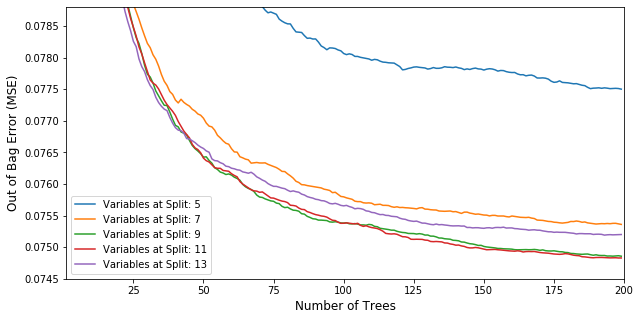

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for label, clf_err in error_rate.items():
    if label =="max_features=3":
        continue
    else:
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

plt.xlim(1, 200)
plt.ylim((0.0745, 0.0788))
plt.xlabel("Number of Trees",fontsize= 12)
plt.ylabel("Out of Bag Error (MSE)",fontsize= 12)
plt.legend(["Variables at Split: 5",
           "Variables at Split: 7", "Variables at Split: 9",
           "Variables at Split: 11", "Variables at Split: 13"])
#plt.savefig("randomforest_paramtune_fin.pdf")


In [84]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 200, max_features = 11,n_jobs=3)




In [85]:
rf.fit(X_trainval,y_trainval)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=11, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=3,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [86]:
from sklearn.metrics import mean_squared_error
print("train error: ",mean_squared_error(y_trainval,rf.predict(X_trainval)))
print("test error: ",mean_squared_error(y_test,rf.predict(X_test)))



train error:  0.009738112560665856
test error:  0.07071408334993624


In [87]:
#import joblib
#filename = 'ultimate_data/rf_predict_seasons_fin.sav'
#joblib.dump(rf, filename)


['ultimate_data/rf_predict_seasons_fin.sav']

# SHAP Values

In [35]:
import joblib
filename = 'ultimate_data/rf_predict_seasons_fin.sav'
rf=joblib.load( filename)



In [86]:
import shap
shap.initjs()

In [87]:
background_data_rf = shap.kmeans(X_trainval, 30) 

In [89]:
shap_sample_rf = shap.sample(X_test, 5000)

In [91]:
explainer_rf = shap.KernelExplainer(model = rf.predict, data = background_data_rf)

In [92]:
shap_values_rf = explainer_rf.shap_values(shap_sample_rf)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [99]:
rf_names = ["Balcony Available", "Actively Rented", "Parking Available",
            "BUNGALOW","FARMHOUSE","HOUSE (UNKNOWN)","LOFT","MAISONETTE",
            "MANSION", "MULTI-FAMILY HOUSE","ONE-TWO-FAMILY HOUSE",
            "PENTHOUSE", "REGULAR APARTMENT","SEMI_DETACHED_HOUSE",
            "SPECIAL_BUILDING","TERRACED HOUSE", "Spring","Summer","Winter",
            
           "Latitude","Longitude","Construction Year","Living Area","Number of Rooms",
           "Population Density (Zip Code)", "Market Size (Zip Code)",
           "Distance to the City Centroid","Time of First Advertisement"]

In [98]:
df.drop(["expose_price_sqm","weeks_on_market","status","object_type_ordinal"],axis=1).columns

Index(['balcony_available_True', 'investment_rent_active_True', 'parking_available_True', 'object_type_BUNGALOW', 'object_type_FARMHOUSE', 'object_type_HOUSE_UNKNOWN', 'object_type_LOFT', 'object_type_MAISONETTE', 'object_type_MANSION', 'object_type_MULTI_FAMILY_HOUSE', 'object_type_ONE_TWO_FAMILY_HOUSE', 'object_type_PENTHOUSE', 'object_type_REGULAR_APARTMENT', 'object_type_SEMI_DETACHED_HOUSE', 'object_type_SPECIAL_BUILDING', 'object_type_TERRACED_HOUSE', 'season_Spring', 'season_Summer', 'season_Winter', 'address_lat', 'address_lng', 'construction_yearfinished', 'structure_area_living', 'structure_rooms_living', 'zip_population_density', 'zip_market_size', 'city_distance', 'time_online'], dtype='object')

In [93]:
#import dill

#with open("ultimate_data/shap_values_rf_1701.pkl","wb") as handle:
#    dill.dump(shap_values_rf,handle)

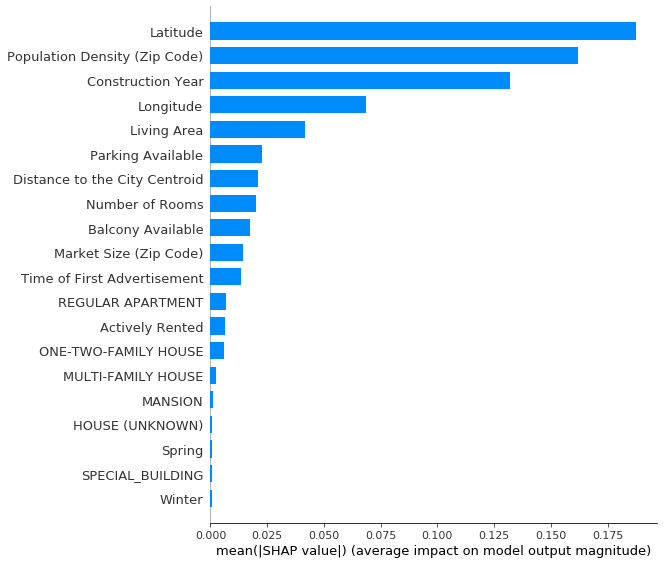

In [107]:
import matplotlib.pyplot as plt

shap.summary_plot(shap_values_rf, shap_val_sample_rf, plot_type="bar",
                  feature_names=rf_names, show=False)


plt.savefig("graphs/rf_shap_absolute.pdf", bbox_inches='tight')


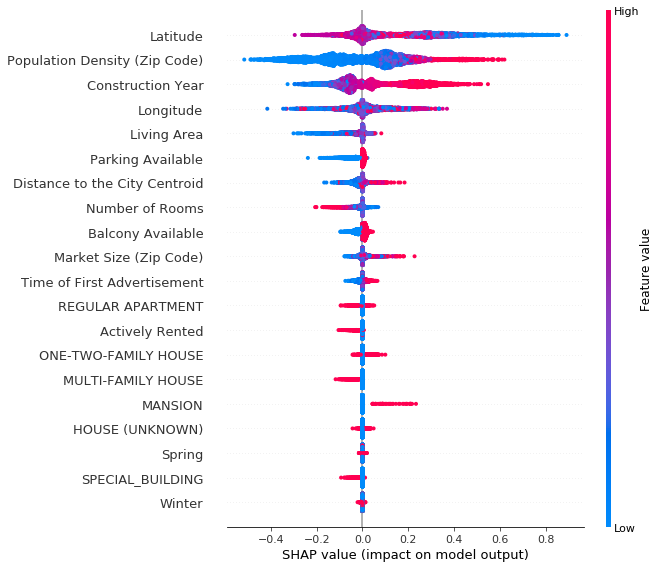

In [108]:
shap.summary_plot(shap_values_rf, shap_val_sample_rf, feature_names = rf_names,
                  show=False) 
plt.savefig("graphs/rf_shap_relative.pdf",bbox_inches='tight')


In [102]:
dop_mlr=surv_data["expose_price_sqm"]/np.exp(lr.predict(X_test_cons))

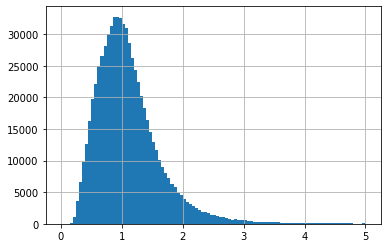

In [110]:
dop_mlr[dop_mlr<5].hist(bins=100)

In [108]:
np.quantile(dop_mlr, [0.1,0.5,0.75,0.99,0.999])

array([0.54644228, 1.01808278, 1.34669474, 3.05051168, 5.23699702])

In [36]:
surv_data = df.iloc[idx_test,:].copy()

In [37]:
surv_data_info = df_info.iloc[idx_test,:].copy()

In [38]:
surv_data["expected_price_sqm"] = np.exp(rf.predict(X_test))

In [39]:
surv_data["DOP"] = surv_data["expose_price_sqm"]/surv_data["expected_price_sqm"]

Text(0, 0.5, 'Frequency (Histogram, 50 bins)')

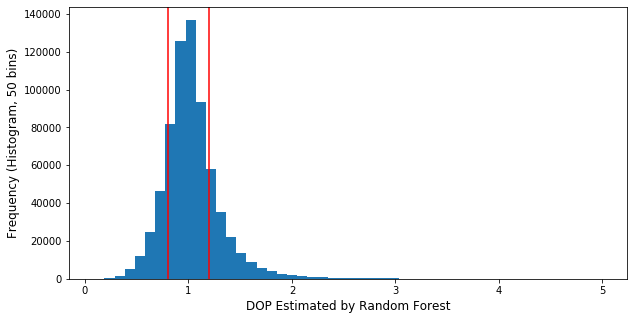

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
ax.axvline(x=0.8, color='r')
ax.axvline(x=1.2, color='r')
surv_data["DOP"][surv_data.DOP<5].plot.hist(bins = 50,ax=ax)
ax.set_xlabel("DOP Estimated by Random Forest",fontsize= 12)
ax.set_ylabel("Frequency (Histogram, 50 bins)",fontsize= 12)


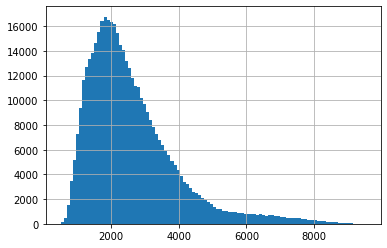

In [112]:
surv_data[(surv_data.DOP >= 0.8) & (surv_data.DOP <= 1.2)].expected_price_sqm.hist(bins=100)

In [43]:
surv_data=surv_data[(surv_data.DOP >= 0.8) & (surv_data.DOP <= 1.2)]

In [44]:
surv_data.shape

(443832, 33)

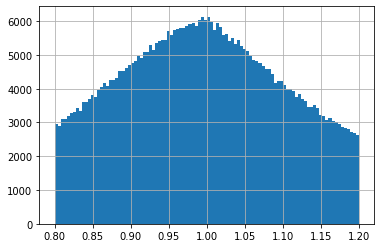

In [45]:
surv_data.DOP.hist(bins=100)

In [46]:
surv_data

,balcony_available_True,investment_rent_active_True,parking_available_True,object_type_FARMHOUSE,object_type_HOUSE_UNKNOWN,object_type_LOFT,object_type_MAISONETTE,object_type_MANSION,object_type_MULTI_FAMILY_HOUSE,object_type_ONE_TWO_FAMILY_HOUSE,object_type_PENTHOUSE,object_type_REGULAR_APARTMENT,object_type_SEMI_DETACHED_HOUSE,object_type_SPECIAL_BUILDING,object_type_TERRACED_HOUSE,season_Spring,season_Summer,season_Winter,address_lat,address_lng,construction_yearfinished,structure_area_living,structure_rooms_living,zip_population_density,object_type_ordinal,zip_market_size,city_distance,time_online,expose_price_sqm,weeks_on_market,status,expected_price_sqm,DOP
376162,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,49.338699,8.648010,2018.0,118.550003,4.0,986.217957,7.0,302.0,0.004658,0.426829,4327.288086,38.0,0.0,3837.040832,1.127767
653342,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,48.024700,10.773090,2020.0,148.460007,5.5,331.082214,1.0,258.0,0.033864,0.731707,4063.047363,19.0,0.0,3826.424280,1.061839
199588,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,49.342388,8.202571,2018.0,113.239998,3.0,255.625641,0.0,300.0,0.055346,0.024390,3266.513672,3.0,1.0,3071.672498,1.063432
914654,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,53.168671,8.691440,1993.0,62.000000,2.0,2874.420654,0.0,244.0,0.119853,0.500000,1532.258057,4.0,1.0,1827.639969,0.838381
660655,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,52.198650,13.585670,1996.0,59.000000,2.0,87.207924,0.0,380.0,0.061685,0.658537,1500.000000,9.0,0.0,1395.668528,1.074754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273521,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,50.837891,12.901680,1900.0,49.000000,2.0,8005.678711,0.0,511.0,0.025403,0.878049,938.775513,5.0,1.0,992.646652,0.945730
136426,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,50.131710,6.956970,2018.0,132.000000,5.0,58.709190,1.0,232.0,0.048240,0.158537,1361.204590,4.0,1.0,1336.247678,1.018677
416837,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,50.496941,8.665640,1976.0,305.000000,10.0,223.207291,4.0,258.0,0.069305,0.865854,1600.445068,2.0,0.0,1393.478978,1.148525
202887,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,50.891731,11.858317,2019.0,144.000000,5.0,366.557861,1.0,342.0,0.018481,0.170732,1424.652832,6.0,0.0,1379.050422,1.033068


In [47]:
surv_data_info

,unique_obj_id_clus,address_geocoded_city,address_geocoded_postalcode,offline_corrected,online_corrected,season,object_type
376162,180243clu2,Sandhausen,69207,2019-05-20 00:00:00,2018-09-03 00:00:00,Fall,MAISONETTE
653342,553715clu0,Buchloe,86807,2019-07-01 00:00:00,2019-02-25 00:00:00,Winter,ONE_TWO_FAMILY_HOUSE
199588,1349972,Neustadt an der Weinstraße,67435,2018-01-29 00:00:00,2018-01-15 00:00:00,Winter,REGULAR_APARTMENT
914654,998730,Bremen,28717,2018-11-05 00:00:00,2018-10-15 00:00:00,Fall,REGULAR_APARTMENT
660655,56481,Mittenwalde,15749,2019-03-11 00:00:00,2019-01-14 00:00:00,Winter,REGULAR_APARTMENT
...,...,...,...,...,...,...,...
136426,1262806,Immerath,54552,2018-04-23 00:00:00,2018-04-02 00:00:00,Spring,ONE_TWO_FAMILY_HOUSE
416837,228052clu1,Langgöns,35428,2019-05-20 00:00:00,2019-05-13 00:00:00,Spring,MULTI_FAMILY_HOUSE
202887,1353617,Hermsdorf,07629,2018-05-14 00:00:00,2018-04-09 00:00:00,Spring,ONE_TWO_FAMILY_HOUSE
346095,1544401,Kelsterbach,65451,2018-05-07 00:00:00,2018-04-30 00:00:00,Spring,HOUSE_UNKNOWN


In [48]:
surv_data_info=surv_data_info[surv_data_info.index.isin(surv_data.index)]

In [81]:
#surv_data.to_pickle("ultimate_data/surv_data_season.pkl")

In [130]:
#surv_data.to_csv("ultimate_data/surv_data_season.csv")

In [82]:
#surv_data_info.to_pickle("ultimate_data/surv_data_info_season.pkl")

# Summary Statistics

In [50]:
cleaned_dataset = pd.concat([surv_data_info,surv_data], axis=1)

In [51]:
cleaned_dataset

,unique_obj_id_clus,address_geocoded_city,address_geocoded_postalcode,offline_corrected,online_corrected,season,object_type,balcony_available_True,investment_rent_active_True,parking_available_True,object_type_FARMHOUSE,object_type_HOUSE_UNKNOWN,object_type_LOFT,object_type_MAISONETTE,object_type_MANSION,object_type_MULTI_FAMILY_HOUSE,object_type_ONE_TWO_FAMILY_HOUSE,object_type_PENTHOUSE,object_type_REGULAR_APARTMENT,object_type_SEMI_DETACHED_HOUSE,object_type_SPECIAL_BUILDING,object_type_TERRACED_HOUSE,season_Spring,season_Summer,season_Winter,address_lat,address_lng,construction_yearfinished,structure_area_living,structure_rooms_living,zip_population_density,object_type_ordinal,zip_market_size,city_distance,time_online,expose_price_sqm,weeks_on_market,status,expected_price_sqm,DOP
376162,180243clu2,Sandhausen,69207,2019-05-20 00:00:00,2018-09-03 00:00:00,Fall,MAISONETTE,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,49.338699,8.648010,2018.0,118.550003,4.0,986.217957,7.0,302.0,0.004658,0.426829,4327.288086,38.0,0.0,3837.040832,1.127767
653342,553715clu0,Buchloe,86807,2019-07-01 00:00:00,2019-02-25 00:00:00,Winter,ONE_TWO_FAMILY_HOUSE,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,48.024700,10.773090,2020.0,148.460007,5.5,331.082214,1.0,258.0,0.033864,0.731707,4063.047363,19.0,0.0,3826.424280,1.061839
199588,1349972,Neustadt an der Weinstraße,67435,2018-01-29 00:00:00,2018-01-15 00:00:00,Winter,REGULAR_APARTMENT,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,49.342388,8.202571,2018.0,113.239998,3.0,255.625641,0.0,300.0,0.055346,0.024390,3266.513672,3.0,1.0,3071.672498,1.063432
914654,998730,Bremen,28717,2018-11-05 00:00:00,2018-10-15 00:00:00,Fall,REGULAR_APARTMENT,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,53.168671,8.691440,1993.0,62.000000,2.0,2874.420654,0.0,244.0,0.119853,0.500000,1532.258057,4.0,1.0,1827.639969,0.838381
660655,56481,Mittenwalde,15749,2019-03-11 00:00:00,2019-01-14 00:00:00,Winter,REGULAR_APARTMENT,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,52.198650,13.585670,1996.0,59.000000,2.0,87.207924,0.0,380.0,0.061685,0.658537,1500.000000,9.0,0.0,1395.668528,1.074754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273521,1440865,Chemnitz,09112,2019-06-17 00:00:00,2019-05-20 00:00:00,Spring,REGULAR_APARTMENT,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,50.837891,12.901680,1900.0,49.000000,2.0,8005.678711,0.0,511.0,0.025403,0.878049,938.775513,5.0,1.0,992.646652,0.945730
136426,1262806,Immerath,54552,2018-04-23 00:00:00,2018-04-02 00:00:00,Spring,ONE_TWO_FAMILY_HOUSE,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,50.131710,6.956970,2018.0,132.000000,5.0,58.709190,1.0,232.0,0.048240,0.158537,1361.204590,4.0,1.0,1336.247678,1.018677
416837,228052clu1,Langgöns,35428,2019-05-20 00:00:00,2019-05-13 00:00:00,Spring,MULTI_FAMILY_HOUSE,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,50.496941,8.665640,1976.0,305.000000,10.0,223.207291,4.0,258.0,0.069305,0.865854,1600.445068,2.0,0.0,1393.478978,1.148525
202887,1353617,Hermsdorf,07629,2018-05-14 00:00:00,2018-04-09 00:00:00,Spring,ONE_TWO_FAMILY_HOUSE,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,50.891731,11.858317,2019.0,144.000000,5.0,366.557861,1.0,342.0,0.018481,0.170732,1424.652832,6.0,0.0,1379.050422,1.033068


In [79]:
for col in surv_data.columns:
    print(col,"\n")
    get_stats(surv_data[col])
    print("---------")

balcony_available_True 

Minimum 0
Maximum 1
Mean 0.6008
Median 1.0
Std 0.4897
---------
investment_rent_active_True 

Minimum 0
Maximum 1
Mean 0.2117
Median 0.0
Std 0.4085
---------
parking_available_True 

Minimum 0
Maximum 1
Mean 0.6003
Median 1.0
Std 0.4898
---------
object_type_BUNGALOW 

Minimum 0
Maximum 1
Mean 0.0167
Median 0.0
Std 0.1281
---------
object_type_FARMHOUSE 

Minimum 0
Maximum 1
Mean 0.0017
Median 0.0
Std 0.0413
---------
object_type_HOUSE_UNKNOWN 

Minimum 0
Maximum 1
Mean 0.0843
Median 0.0
Std 0.2778
---------
object_type_LOFT 

Minimum 0
Maximum 1
Mean 0.0012
Median 0.0
Std 0.0344
---------
object_type_MAISONETTE 

Minimum 0
Maximum 1
Mean 0.0234
Median 0.0
Std 0.1512
---------
object_type_MANSION 

Minimum 0
Maximum 1
Mean 0.0077
Median 0.0
Std 0.0874
---------
object_type_MULTI_FAMILY_HOUSE 

Minimum 0
Maximum 1
Mean 0.0488
Median 0.0
Std 0.2154
---------
object_type_ONE_TWO_FAMILY_HOUSE 

Minimum 0
Maximum 1
Mean 0.2434
Median 0.0
Std 0.4291
---------
object_

# Censoring Check

In [86]:
cleaned_dataset["month_year"]=cleaned_dataset.online_corrected.dt.year.astype(str) +"_"+ cleaned_dataset.online_corrected.dt.month.astype(str)



month_count_status0 = cleaned_dataset[(cleaned_dataset.status== 0.0)][["unique_obj_id_clus","month_year"]].\
groupby("month_year").count().reset_index() \
.sort_values(['unique_obj_id_clus'], ascending=False) 

month_count_status1 = cleaned_dataset[(cleaned_dataset.status== 1.0)][["unique_obj_id_clus","month_year"]].\
groupby("month_year").count().reset_index() \
.sort_values(['unique_obj_id_clus'], ascending=False) 

month_mean_status0 = cleaned_dataset[(cleaned_dataset.status== 0.0)][["weeks_on_market","expose_price_sqm","month_year"]].\
groupby("month_year").mean().reset_index() \
.sort_values(['weeks_on_market'], ascending=False) 

month_mean_status1 = cleaned_dataset[(cleaned_dataset.status== 1.0)][["weeks_on_market","expose_price_sqm","month_year"]].\
groupby("month_year").mean().reset_index() \
.sort_values(['weeks_on_market'], ascending=False) 



month = pd.merge(month_count_status0, month_count_status1, how="left", on = "month_year",suffixes = ("_0","_1"))

month = pd.merge(month, month_mean_status0, how="left", on = "month_year",suffixes = ("_0","_1"))
month = pd.merge(month, month_mean_status1, how="left", on = "month_year",suffixes = ("_0","_1"))

import datetime as dt
month['month_year'] = month['month_year'].apply(lambda x: 
                                    dt.datetime.strptime(x,'%Y_%m'))



In [87]:
month = month.sort_values("month_year")

In [88]:
month

,month_year,unique_obj_id_clus_0,unique_obj_id_clus_1,weeks_on_market_0,expose_price_sqm_0,weeks_on_market_1,expose_price_sqm_1
3,2018-01-01,9367,16978,20.791182,2742.547119,10.172105,2579.065430
2,2018-02-01,9604,15876,17.820074,2739.258545,8.703136,2615.062256
1,2018-03-01,11553,17466,15.361465,2772.576416,7.556567,2657.187988
0,2018-04-01,15334,20138,11.338594,2781.034180,7.060880,2658.041016
4,2018-05-01,6931,10371,10.923820,2853.043701,7.915245,2682.611572
11,2018-06-01,3494,10349,21.301661,2895.347656,8.797565,2677.207520
6,2018-07-01,4011,12469,21.288706,2907.849609,8.492021,2702.484863
14,2018-08-01,2895,8182,21.581347,2850.856201,9.669885,2654.236084
8,2018-09-01,3767,10420,19.799841,3007.052490,8.190403,2794.770020
5,2018-10-01,4105,11953,19.805847,3013.731934,8.645863,2811.935547


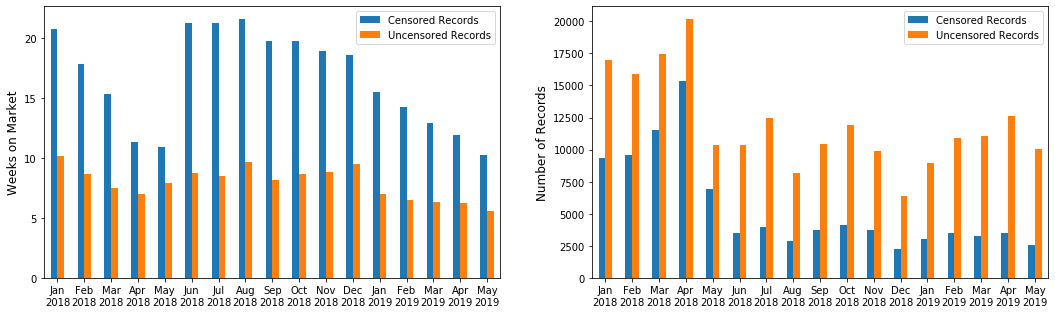

In [104]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(18,5))
month.plot.bar(x="month_year",y=["weeks_on_market_0","weeks_on_market_1"],ax = axes[0])

def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    
    month += f'\n{label.year}'
    return month

axes[0].set_xticklabels(map(lambda x: line_format(x), month.month_year),rotation=0)
axes[0].set_xlabel(" ")
axes[0].set_ylabel("Weeks on Market",fontsize=12)
axes[0].legend(["Censored Records","Uncensored Records"])


month.plot.bar(x="month_year",y=["unique_obj_id_clus_0","unique_obj_id_clus_1"],ax = axes[1])


axes[1].set_xticklabels(map(lambda x: line_format(x), month.month_year),rotation=0)
axes[1].set_xlabel(" ")
axes[1].set_ylabel("Number of Records",fontsize=12)
axes[1].legend(["Censored Records","Uncensored Records"])

plt.savefig("graphs/Fig1_censored_check_week.pdf")


# Top Cities

In [106]:
city_count = cleaned_dataset[["unique_obj_id_clus","address_geocoded_city"]].\
groupby("address_geocoded_city").count().reset_index() \
.sort_values(['unique_obj_id_clus'], ascending=False) 

city_mean = cleaned_dataset[["weeks_on_market","expose_price_sqm","address_geocoded_city"]].\
groupby("address_geocoded_city").mean().reset_index() \
.sort_values(['weeks_on_market'], ascending=False) 

city = pd.merge(city_count, city_mean, how="left", on = "address_geocoded_city")

city["perc"] = city["unique_obj_id_clus"] / cleaned_dataset.shape[0]

In [108]:
city.iloc[:20]

,address_geocoded_city,unique_obj_id_clus,weeks_on_market,expose_price_sqm,perc
0,Berlin,18014,11.739869,4175.336426,0.060626
1,München,7766,8.838655,7074.832031,0.026137
2,Hamburg,6442,9.762807,4225.533203,0.021681
3,Köln,3495,7.805150,3487.167236,0.011762
4,Leipzig,3436,13.495052,2244.668457,0.011564
5,Frankfurt am Main,2863,8.938526,4773.504395,0.009635
6,Dresden,2842,12.713230,2256.422363,0.009565
7,Bremen,2765,9.108137,2242.025146,0.009306
8,Stuttgart,2714,7.337509,4307.399902,0.009134
9,Hannover,2507,8.488632,2792.682861,0.008437
